<a href="https://colab.research.google.com/github/SamuelEiler/wgan/blob/main/SineGANtrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import random


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class MinibatchDiscrimination(torch.nn.Module):
   def __init__(self,input_features,output_features,minibatch_normal_init, hidden_features=16):
      super(MinibatchDiscrimination,self).__init__()
      
      self.input_features = input_features
      self.output_features = output_features
      self.hidden_features = hidden_features
      self.T = torch.nn.Parameter(torch.randn(self.input_features,self.output_features, self.hidden_features))
      if minibatch_normal_init == True:
        nn.init.normal_(self.T, 0,1)
      
   def forward(self,x):
      M = torch.mm(x,self.T.view(self.input_features,-1))
      M = M.view(-1, self.output_features, self.hidden_features).unsqueeze(0)
      M_t = M.permute(1, 0, 2, 3)
      # Broadcasting reduces the matrix subtraction to the form desired in the paper
      out = torch.sum(torch.exp(-(torch.abs(M - M_t).sum(3))), dim=0) - 1
      
      return torch.cat([x, out], 1)
    

# Use minibatch = 0 for no minibatch discriminiation layer to be used in the architecture. If minibatch > 0, then minibatch is the number of output dimensions of the MBD layer.
class Discriminator(torch.nn.Module):
  def __init__(self,seq_length,batch_size,minibatch_normal_init, n_features = 1, num_cv = 1, minibatch = 0, cv1_out= 10, cv1_k = 3, cv1_s = 4, p1_k = 3, p1_s = 3, cv2_out = 10, cv2_k = 3, cv2_s = 3 ,p2_k = 3, p2_s = 3):
      super(Discriminator,self).__init__()
      self.n_features = n_features
      self.seq_length = seq_length
      self.batch_size = batch_size
      self.num_cv = num_cv
      self.minibatch = minibatch
      self.cv1_dims = int((((((seq_length - cv1_k)/cv1_s) + 1)-p1_k)/p1_s)+1)
      self.cv2_dims = int((((((self.cv1_dims - cv2_k)/cv2_s) + 1)-p2_k)/p2_s)+1)
      self.cv1_out = cv1_out
      self.cv2_out = cv2_out
      
      #input should be size (batch_size,num_features,seq_length) for the convolution layer
      self.CV1 = torch.nn.Sequential(
                  torch.nn.Conv1d(in_channels = self.n_features, out_channels = int(cv1_out),kernel_size = int(cv1_k), stride = int(cv1_s))
                  ,torch.nn.ReLU()        
                  ,torch.nn.MaxPool1d(kernel_size = int(p1_k), stride = int(p1_s))   
                 )
      
      # 2 convolutional layers
      if self.num_cv > 1:
        self.CV2 = torch.nn.Sequential(
                      torch.nn.Conv1d(in_channels = int(cv1_out), out_channels = int(cv2_out) ,kernel_size =int(cv2_k), stride = int(cv2_s))
                      ,torch.nn.ReLU()
                      ,torch.nn.MaxPool1d(kernel_size = int(p2_k), stride = int(p2_s))
                  )
        
        #Adding a minibatch discriminator layer to add a cripple affect to the discriminator so that it needs to generate sequences that are different from each other.
        
        if   self.minibatch > 0:
          self.mb1 = MinibatchDiscrimination(self.cv2_dims*cv2_out,self.minibatch, minibatch_normal_init)
          self.out = torch.nn.Sequential(torch.nn.Linear(int(self.cv2_dims*cv2_out)+self.minibatch,1),torch.nn.Sigmoid()) # to make sure the output is between 0 and 1
        else:
          self.out = torch.nn.Sequential(torch.nn.Linear(int(self.cv2_dims*cv2_out),1),torch.nn.Sigmoid()) # to make sure the output is between 0 and 1 
      
      # 1 convolutional layer
      else:
        #Adding a minibatch discriminator layer to add a cripple affect to the discriminator so that it needs to generate sequences that are different from each other.
        if self.minibatch > 0 :    
          self.mb1 = MinibatchDiscrimination(int(self.cv1_dims*cv1_out),self.minibatch, minibatch_normal_init)
          self.out = torch.nn.Sequential(torch.nn.Linear(int(self.cv1_dims*cv1_out)+self.minibatch,1),torch.nn.Dropout(0.2),torch.nn.Sigmoid()) # to make sure the output is between 0 and 1
        else:
          self.out = torch.nn.Sequential(torch.nn.Linear(int(self.cv1_dims*cv1_out),1),torch.nn.Sigmoid())  
      
      

  def forward(self,x):
      x = self.CV1(x.view(self.batch_size,1,self.seq_length))
          
      #2 Convolutional Layers
      if self.num_cv > 1:   
        x = self.CV2(x)
        x = x.view(self.batch_size,-1)
        
        #2 CNN with minibatch discrimination
        if self.minibatch > 0:
             x = self.mb1(x.squeeze())
             x = self.out(x.squeeze())
             
        #2 CNN and no minibatch discrimination
        else:
             x = self.out(x.squeeze())
        
      # 1 Convolutional Layer
      else: 
        x = x.view(self.batch_size,-1)
       
        #1 convolutional Layer and minibatch discrimination
        if self.minibatch > 0:
             x = self.mb1(x)
             x = self.out(x)
        
        #1 convolutional Layer and no minibatch discrimination
        else:
             x = self.out(x)    
      return x
  


class Generator(torch.nn.Module):
  #seq_length not important
  def __init__(self,seq_length,batch_size,n_features = 1, hidden_dim = 50, num_layers = 2, tanh_output = False, bidirectional = False):
      super(Generator,self).__init__()
      self.n_features = n_features
      self.hidden_dim = hidden_dim
      self.num_layers = num_layers
      self.seq_length = seq_length
      self.batch_size = batch_size
      self.tanh_output = tanh_output
      self.bidirectional = bidirectional
      
      #Checking if the architecture uses a BiLSTM and setting the output parameters as appropriate.
      if self.bidirectional == True:
        self.num_dirs = 2
      else:
        self.num_dirs = 1
      
      
      self.layer1 = torch.nn.LSTM(input_size = self.n_features, hidden_size = self.hidden_dim, num_layers = self.num_layers,batch_first = True, bidirectional = self.bidirectional )
      self.out = torch.nn.Linear(self.hidden_dim,1) # to make sure the output is between 0 and 1 - removed ,torch.nn.Sigmoid()
  
  def forward(self,x):
      self.seq_length = x.size(1)

      h_0 = torch.zeros(self.num_layers*self.num_dirs, self.batch_size, self.hidden_dim, requires_grad=True).to(device)
      c_0 = torch.zeros(self.num_layers*self.num_dirs, self.batch_size, self.hidden_dim, requires_grad=True).to(device)
      #x, _ = self.layer1(x.view(self.batch_size,self.seq_length,1), (h_0, c_0)) 
      x, _ = self.layer1(x.view(self.batch_size,self.seq_length, noise_features), (h_0, c_0)) #--------------------------------noise_features ---------------------------------------

      if self.bidirectional == True:
        x = x.view(x.size(0), x.size(1), 2, -1).sum(2).view(x.size(0), x.size(1), -1)
      
      #Note that the output of the bidirectional LSTM is in the form (batch_size,seq_lenth,num_dirs*hidden_dim) To separate the directions, we can use 
      #x.view(self.batch_size,self.seq_length,self.num_dirs, self.hidden_dim)
      x = self.out(x)

      return x.squeeze() #,hidden 


def noise(batchsize, seq_length, noise_features):
    noise = torch.ones( (batchsize, seq_length, noise_features)).to(device)
    for b in range(batchsize):
      r1 = random.uniform(-1,1)
      r2 = random.uniform(-1,1)
      r3 = random.uniform(-1,1)    #-> noise_features = 3
      #r4 = random.uniform(-1,1)   #-> noise_features = 4 ...
      for i in range(seq_length):
        noise[b][i][0] = r1  
        noise[b][i][1] = r2 
        noise[b][i][2] = r3 
        #noise[b][i][3] = r4
    return noise


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class SineData(Dataset):
  #This is the class for teh ECG Data that we need to load, transform and then use in teh dataloader.
  def __init__(self,source_file,transform = None):
    self.source_file = source_file
    self.data  = pd.read_csv(source_file, header = None)
    self.transform = transform
    
  def __len__(self):
    return self.data.shape[0]
    
  def __getitem__(self,idx):
    
    sample = self.data.iloc[idx]
    
    if self.transform:
        sample = self.transform(sample)
        
    return sample   

"""Including the function that will transform the dataframe to a pytorch tensor"""
class PD_to_Tensor(object):
    def __call__(self,sample):
      return torch.tensor(sample.values).to(device=device, dtype=float)

In [97]:
import pandas as pd
import numpy as np
import random



dataPath = '/content/drive/My Drive/MasterThesis/SineGAN/dataset'  
os.makedirs(dataPath) 

trainingset_size = 10000
testset_size = 3000

"""Create a training set of sine waves with 10000 records"""
#a = np.arange(0.1,0.9,0.02)
x = np.arange(0,20,0.5)
#r = np.arange(2,6.1,0.1)
count = 0
fs = len(x)
y = np.zeros((1,len(x)))

for n in range(trainingset_size):
  amp = random.uniform(0.1, 0.9)
  rad = random.uniform(2, 6)
  phase = random.uniform(-fs/0.5*np.pi,fs/0.5*np.pi)
  y = np.append(y, amp*np.sin(((2*np.pi*rad*x)+phase)/fs).reshape((1,len(x))),axis = 0)
     
data = pd.DataFrame(y[1:][:])  
data.to_csv(dataPath + '/sinedata_v2.csv', header = False, index = False)

"""Creating a test set of sine waves with 3000 records"""
a = np.arange(0.1,0.9,0.02)
x = np.arange(0,20,0.5)
r = np.arange(2,6.1,0.1)
count = 0
fs = len(x)
y = np.zeros((1,len(x)))

for n in range(testset_size):
  amp = a[random.randint(0,len(a)-1)]
  rad = r[random.randint(0,len(r)-1)]
  phase = random.uniform(-1,1)*np.pi

  y = np.append(y,amp*np.sin(((2*np.pi*rad*x)+phase)/fs).reshape((1,len(x))),axis = 0)
  
data = pd.DataFrame(y[1:][:])  
data.to_csv(dataPath + '/sinedata_test_v2.csv', header = False, index = False)

In [11]:
from __future__ import division
import torch
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from torchvision import transforms
from torch.autograd.variable import Variable
sns.set(rc={'figure.figsize':(11, 8)})

import datetime 
from datetime import date
today = date.today()

import random
import json as js
import pickle
import os
import tqdm.notebook as tq


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f'Using : {device}')
    print(torch.cuda.get_device_name(device))
else :
    print(f'Using : {device}')



def pdist(sample_1, sample_2, norm=2, eps=1e-5):
    n_1, n_2 = sample_1.size(0), sample_2.size(0)
    norm = float(norm)
    
    if norm == 2.:
        norms_1 = torch.sum(sample_1**2, dim=1, keepdim=True)
        norms_2 = torch.sum(sample_2**2, dim=1, keepdim=True)
        norms = (norms_1.expand(n_1, n_2) +
                 norms_2.transpose(0, 1).expand(n_1, n_2))
        distances_squared = norms - 2 * sample_1.mm(sample_2.t())
        return torch.sqrt(eps + torch.abs(distances_squared))
    else:
        dim = sample_1.size(1)
        expanded_1 = sample_1.unsqueeze(1).expand(n_1, n_2, dim)
        expanded_2 = sample_2.unsqueeze(0).expand(n_1, n_2, dim)
        differences = torch.abs(expanded_1 - expanded_2) ** norm
        inner = torch.sum(differences, dim=2, keepdim=False)
        return (eps + inner) ** (1. / norm)

def permutation_test_mat(matrix,n_1,  n_2,  n_permutations, a00=1,  a11=1,  a01=0):
    n = n_1 + n_2
    pi = np.zeros(n, dtype=np.int8)
    pi[n_1:] = 1

    larger = 0.
    count = 0
    
    for sample_n in range(1 + n_permutations):
        count = 0.
        for i in range(n):
            for j in range(i, n):
                mij = matrix[i, j] + matrix[j, i]
                if pi[i] == pi[j] == 0:
                    count += a00 * mij
                elif pi[i] == pi[j] == 1:
                    count += a11 * mij
                else:
                    count += a01 * mij
        if sample_n == 0:
            statistic = count
        elif statistic <= count:
            larger += 1

        np.random.shuffle(pi)

    return larger / n_permutations


class MMDStatistic:
    def __init__(self, n_1, n_2):
        self.n_1 = n_1
        self.n_2 = n_2

        # The three constants used in the test.
        self.a00 = 1. / (n_1 * (n_1 - 1))
        self.a11 = 1. / (n_2 * (n_2 - 1))
        self.a01 = - 1. / (n_1 * n_2)

    def __call__(self, sample_1, sample_2, alphas, ret_matrix=False):

        sample_12 = torch.cat((sample_1, sample_2), 0)
        distances = pdist(sample_12, sample_12, norm=2)

        kernels = None
        for alpha in alphas:
            kernels_a = torch.exp(- alpha * distances ** 2)
            if kernels is None:
                kernels = kernels_a
            else:
                kernels = kernels + kernels_a

        k_1 = kernels[:self.n_1, :self.n_1]
        k_2 = kernels[self.n_1:, self.n_1:]
        k_12 = kernels[:self.n_1, self.n_1:]

        mmd = (2 * self.a01 * k_12.sum() +
               self.a00 * (k_1.sum() - torch.trace(k_1)) +
               self.a11 * (k_2.sum() - torch.trace(k_2)))
        if ret_matrix:
            return mmd, kernels
        else:
            return mmd


    def pval(self, distances, n_permutations=1000):
        if isinstance(distances, Variable):
            distances = distances.data
        return permutation_test_mat(distances.cpu().numpy(),
                                    self.n_1, self.n_2,
                                    n_permutations,
                                    a00=self.a00, a11=self.a11, a01=self.a01)

def saveModel(version): 
    torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizerG_state_dict': generator_opt.state_dict(),
            'optimizerD_state_dict': discriminator_opt.state_dict()   
            }, path +'/model'+str(version)+'.tar')



def pairwisedistances(X,Y,norm=2):
    dist = pdist(X,Y,norm)
    return np.median(dist.numpy())


def GetSineData(source_file):
  compose = transforms.Compose([PD_to_Tensor()])
  return SineData(source_file ,transform = compose)
  
dataPath = '/content/drive/My Drive/MasterThesis/SineGAN/dataset'  

"""Creating the training set of sine signals"""
source_filename =  dataPath + '/sinedata_v2.csv'#./sinedata_v2.csv'
sine_data = GetSineData(source_file = source_filename)

noise_features = 3 #frequency, amplitude, shift
sample_size = 50 #batch size needed for Data Loader and the noise creator function.
data_loader = torch.utils.data.DataLoader(sine_data, batch_size=sample_size, shuffle=True)
# Num batches
num_batches = len(data_loader)

"""Creating the Test Set"""
test_filename = dataPath + '/sinedata_test_v2.csv' #'./sinedata_test_v2.csv'

sine_data_test = GetSineData(source_file = test_filename)
data_loader_test = torch.utils.data.DataLoader(sine_data_test, batch_size=sample_size, shuffle=True)

"""Defining parameters"""
seq_length = sine_data[0].size()[0] #Number of features

#Params for the generator
hidden_nodes_g = 50
layers = 2
tanh_layer = False
bidir = True

#No. of training rounds per epoch
D_rounds = 5
G_rounds = 1
num_epoch = 15
learning_rate = 0.0002
    
#Params for the Discriminator
minibatch_layer = 5
minibatch_normal_init_ = True
num_cvs = 1
cv1_out= 10
cv1_k = 3
cv1_s = 1
p1_k = 3
p1_s = 2
cv2_out = 5
cv2_k = 3
cv2_s = 1
p2_k = 3
p2_s = 2


trainCounter = 3
loadVersion = 2
loadModel = True

""" Evaluation of GAN with 1 CNN Layer in Discriminator
##Generator and Discriminator training phase
"""
#minibatch_out = [5] #[0,3,5,8,10]
#for minibatch_layer in tq.tqdm(minibatch_out):
#path = "./output/Run_"+str(today.strftime("%d_%m_%Y"))+"_"+ str(datetime.datetime.now().time()).split('.')[0]
path = '/content/drive/My Drive/MasterThesis/SineGAN/' + str(trainCounter)
loadPath = '/content/drive/My Drive/MasterThesis/SineGAN/' + str(loadVersion) 
os.makedirs(path)  


dict = {'data' : source_filename, 
        'sample_size' : sample_size, 
        'noise_features' : noise_features,
        'seq_length' : seq_length,
        'num_layers': layers, 
        'tanh_layer': tanh_layer,
        'bidir': bidir,
        'hidden_dims_generator': hidden_nodes_g, 
        'minibatch_layer': minibatch_layer,
        'minibatch_normal_init_' : minibatch_normal_init_,
        'num_cvs':num_cvs,
        'cv1_out':cv1_out,
        'cv1_k':cv1_k,
        'cv1_s':cv1_s,
        'p1_k':p1_k,
        'p1_s':p1_s,
        'cv2_out':cv2_out,
        'cv2_k':cv2_k,
        'cv2_s':cv2_s,
        'p2_k':p2_k,
        'p2_s':p2_s,
        'num_epoch':num_epoch,
        'D_rounds': D_rounds,
        'G_rounds': G_rounds,  
        'learning_rate' : learning_rate
        }
#Printing the settings used to file
json = js.dumps(dict)
f = open(path+"/settings.json","w")
f.write(json)
f.close()

#Initialising the generator and discriminator
generator = Generator(seq_length,sample_size,n_features = noise_features, hidden_dim =  hidden_nodes_g, tanh_output = tanh_layer, bidirectional = bidir).to(device)
discriminator = Discriminator(seq_length, sample_size ,minibatch_normal_init = minibatch_normal_init_, minibatch = minibatch_layer,num_cv = num_cvs, cv1_out = cv1_out,cv1_k = cv1_k, cv1_s = cv1_s, p1_k = p1_k, p1_s = p1_s, cv2_out= cv2_out, cv2_k = cv2_k, cv2_s = cv2_s, p2_k = p2_k, p2_s = p2_s).to(device)
#Loss function 
loss_1 = torch.nn.BCELoss()



#Defining optimizer
discriminator_opt = torch.optim.Adam(discriminator.parameters(),lr = learning_rate)
generator_opt = torch.optim.Adam(generator.parameters(),lr = learning_rate)
if loadModel:
    checkpoint = torch.load(loadPath + '/modelComplete' + str(loadVersion)+'.tar')
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    generator_opt.load_state_dict(checkpoint['optimizerG_state_dict'])
    discriminator_opt.load_state_dict(checkpoint['optimizerD_state_dict'])
    print('Models loaded!')

generator.train()
discriminator.train()

G_losses = []
D_losses = []
mmd_list = []
series_list = np.zeros((1,seq_length))


for n in tq.tqdm(range(num_epoch)):
    print(f'Epoch: {n}:')
    for n_batch, sample_data in  enumerate(tq.tqdm(data_loader)): #tq.tqdm(enumerate(data_loader)): 
    
      for d in range(D_rounds):
        #Train Discriminator on Fake Data
        discriminator.zero_grad()


        #Generating the noise and label data
        #noise_sample = Variable(noise(len(sample_data),seq_length))
        noise_sample = noise(len(sample_data), seq_length,noise_features )

        #Use this line if generator outputs hidden states: dis_fake_data, (h_g_n,c_g_n) = generator.forward(noise_sample,h_g)
        dis_fake_data = generator.forward(noise_sample).detach()

        y_pred_fake = discriminator(dis_fake_data)

        loss_fake = loss_1(y_pred_fake,torch.zeros([len(sample_data),1]).to(device))
        loss_fake.backward()    

        #Train Discriminator on Real Data 

        real_data = Variable(sample_data.float()).to(device)    
        y_pred_real  = discriminator.forward(real_data)

        loss_real = loss_1(y_pred_real,torch.ones([len(sample_data),1]).to(device))
        loss_real.backward()

        discriminator_opt.step() #Updating the weights based on the predictions for both real and fake calculations.



      #Train Generator  
      for g in range(G_rounds):
        generator.zero_grad()

        #noise_sample = Variable(noise(len(sample_data), seq_length))
        noise_sample = noise(len(sample_data), seq_length, noise_features)


        #Use this line if generator outputs hidden states: gen_fake_data, (h_g_n,c_g_n) = generator.forward(noise_sample,h_g)
        gen_fake_data = generator.forward(noise_sample)
        y_pred_gen = discriminator(gen_fake_data)

        error_gen = loss_1(y_pred_gen,torch.ones([len(sample_data),1]).to(device))
        error_gen.backward()
        generator_opt.step()

    torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizerG_state_dict': generator_opt.state_dict(),
            'optimizerD_state_dict': discriminator_opt.state_dict()   
            }, '/content/drive/My Drive/MasterThesis/SineGAN/trainModelEpoch' + str(n)+'.tar')


    if (n_batch%100 == 0):
        print("\nERRORS FOR EPOCH: "+str(n)+"/"+str(num_epoch)+", batch_num: "+str(n_batch)+"/"+str(num_batches))
        print("Discriminator error: "+str(loss_fake+loss_real))
        print("Generator error: "+str(error_gen))
    if n_batch ==( num_batches - 1):
        G_losses.append(error_gen.item())
        D_losses.append((loss_real+loss_fake).item())
        
        #Saving the parameters of the model to file for each epoch
        saveModel(n)
        #torch.save(generator.state_dict(), path+'/generator_state_'+str(n)+'.pt')
        #torch.save(discriminator.state_dict(),path+ '/discriminator_state_'+str(n)+'.pt')

      # Check how the generator is doing by saving G's output on fixed_noise
    
        with torch.no_grad():
            fake = generator(noise(len(sample_data), seq_length, noise_features)).detach().cpu()
            generated_sample = torch.zeros(1,seq_length).to(device)
            testloader=torch.utils.data.DataLoader(sine_data_test, batch_size=sample_size, shuffle=True)
            
            
            for n_batch, sample_data in enumerate(testloader):
              noise_sample_test = noise(sample_size, seq_length, noise_features)
              generated_data = generator.forward(noise_sample_test).detach().squeeze()
              generated_sample = torch.cat((generated_sample,generated_data),dim = 0)
            
            
            # Getting the MMD Statistic for each Training Epoch
            generated_sample = generated_sample[1:][:]
            sigma = [pairwisedistances(sine_data_test[:].type(torch.DoubleTensor),generated_sample.type(torch.DoubleTensor).squeeze())] 
            mmd = MMDStatistic(len(sine_data_test[:]),generated_sample.size(0))
            mmd_eval = mmd(sine_data_test[:].type(torch.DoubleTensor),generated_sample.type(torch.DoubleTensor).squeeze(),sigma, ret_matrix=False)
            mmd_list.append(mmd_eval.item())
            
        
        series_list = np.append(series_list,fake[0].numpy().reshape((1,seq_length)),axis=0)

#Dumping the errors and mmd evaluations for each training epoch.
with open(path+'/generator_losses.txt', 'wb') as fp:
    pickle.dump(G_losses, fp)
with open(path+'/discriminator_losses.txt', 'wb') as fp:
    pickle.dump(D_losses, fp)   
with open(path+'/mmd_list.txt', 'wb') as fp:
    pickle.dump(mmd_list, fp)

#Plotting the error graph
plt.plot(G_losses,'-r',label='Generator Error')
plt.plot(D_losses, '-b', label = 'Discriminator Error')
plt.title('GAN Errors in Training')
plt.legend()
plt.savefig(path+'/GAN_errors.png')
plt.close()


#Plot a figure for each training epoch with the MMD value in the title
i = 0
while i < num_epoch:
  if i%3==0:
    fig, ax = plt.subplots(3,1,constrained_layout=True)
    fig.suptitle("Generated fake data")
  for j in range(0,3):
    ax[j].plot(series_list[i][:])
    ax[j].set_title('Epoch '+str(i)+ ', MMD: %.4f' % (mmd_list[i]))
    i = i+1
  plt.savefig(path+'/Training_Epoch_Samples_MMD_'+str(i)+'.png')
  plt.close(fig) 
  
#Checking the diversity of the samples:
generator.eval()
test_noise_sample = noise(sample_size, seq_length, noise_features)
gen_data= generator.forward(test_noise_sample).detach()

plt.title("Generated Sine Waves")
plt.plot(gen_data[random.randint(0,sample_size-1)].tolist(),'-b')
plt.plot(gen_data[random.randint(0,sample_size-1)].tolist(),'-r')
plt.plot(gen_data[random.randint(0,sample_size-1)].tolist(),'-g')
plt.plot(gen_data[random.randint(0,sample_size-1)].tolist(),'-', color = 'orange')
plt.savefig(path+'/Generated_Data_Sample1.png')
plt.close()

print('Training Complete!')
torch.save({
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizerG_state_dict': generator_opt.state_dict(),
        'optimizerD_state_dict': discriminator_opt.state_dict()   
        }, path + '/modelComplete' + str(trainCounter)+'.tar')
print('Model saved in Drive!')


Using : cuda:0
Tesla T4
Models loaded!


Epoch: 0:



Epoch: 1:



Epoch: 2:



Epoch: 3:



Epoch: 4:



Epoch: 5:



Epoch: 6:



Epoch: 7:



Epoch: 8:



Epoch: 9:



Epoch: 10:



Epoch: 11:



Epoch: 12:



Epoch: 13:



Epoch: 14:




Training Complete!
Model saved in Drive!


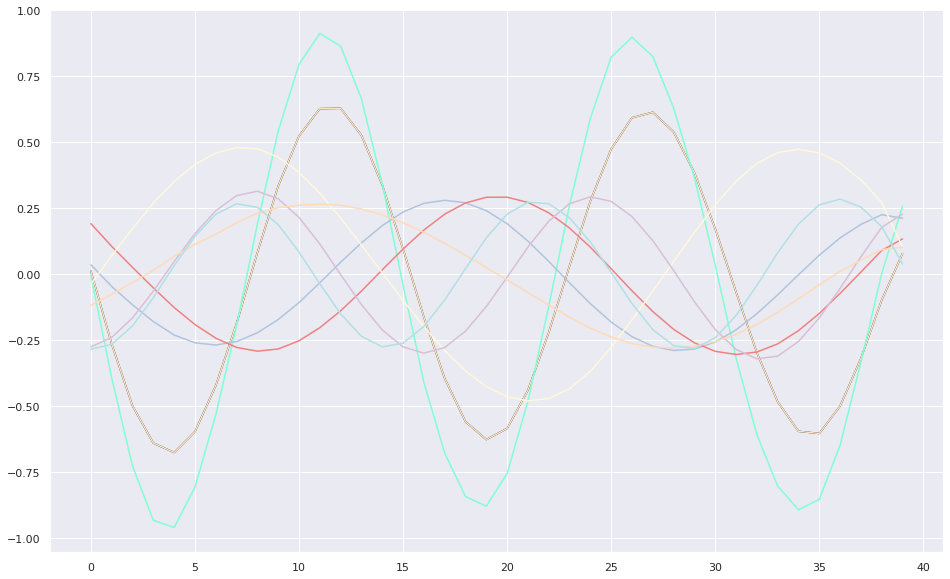

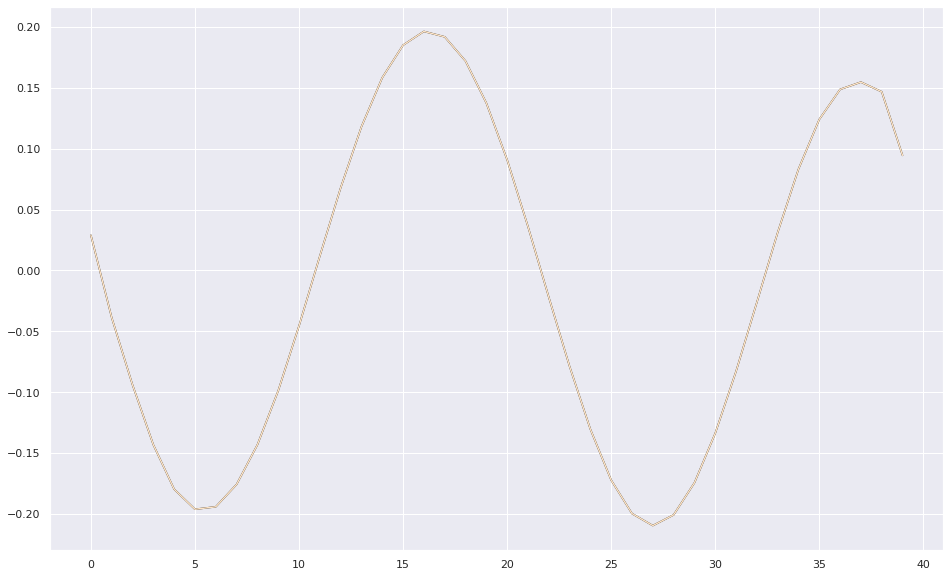

In [12]:
from mpl_toolkits.mplot3d import Axes3D



testNoise = noise(sample_size, int(seq_length*1), noise_features)
testOut = generator(testNoise)


plt.show()
plt.figure(figsize=(16,10))
plt.plot(testOut[0].detach().cpu(), 'black') 
plt.plot(testOut[0].detach().cpu() , 'bisque')
plt.plot(testOut[1].detach().cpu() , 'aquamarine')
plt.plot(testOut[2].detach().cpu() , 'lightsteelblue')
plt.plot(testOut[3].detach().cpu() , 'lightcoral')
plt.plot(testOut[4].detach().cpu() , 'cornsilk')
plt.plot(testOut[5].detach().cpu() , 'thistle')
plt.plot(testOut[6].detach().cpu() , 'peachpuff')
plt.plot(testOut[7].detach().cpu() , 'powderblue')
plt.show()


r1u =  0 # delta
r1l = -0 # delta
r2u =  0 # amplitude
r2l = -0 # amplitude
r3u =  0 # freq (+ amplitude)
r3l = -1 # freq (+ amplitude)

for b in range(2):
  r1 = random.uniform(r1u,r1l)
  r2 = random.uniform(r2u,r2l)
  r3 = random.uniform(r3u,r3l)    #-> noise_features = 3
  #r4 = random.uniform(-1,1)   #-> noise_features = 4 ...
  for i in range(seq_length):
    testNoise[b][i][0] = r1  
    testNoise[b][i][1] = r2 
    testNoise[b][i][2] = r3 
    #noise[b][i][3] = r4
    
# fig = plt.figure(constrained_layout=True)
# ax = fig.add_subplot( projection='3d')  
# for b in range(sample_size):
#     ax.scatter(testNoise[b][0][0].cpu(), testNoise[b][0][1].cpu(), testNoise[b][0][2].cpu(), marker=".")

# ax.set_xlabel('Freq')
# ax.set_ylabel('Ampl')
# ax.set_zlabel('delta')
# plt.show()
for i in range(seq_length):
    testNoise[0][i][0] = r1  
    testNoise[0][i][1] = r2 
    testNoise[0][i][2] = r3 
    testNoise[1][i][0] = r1  
    testNoise[1][i][1] = r2 
    testNoise[1][i][2] = r3 
testOut = generator(testNoise)

plt.show()
plt.figure(figsize=(16,10))
plt.plot(testOut[0].detach().cpu(), 'black') 
plt.plot(testOut[0].detach().cpu() , 'bisque')
plt.show()


80
torch.Size([50, 80, 3])


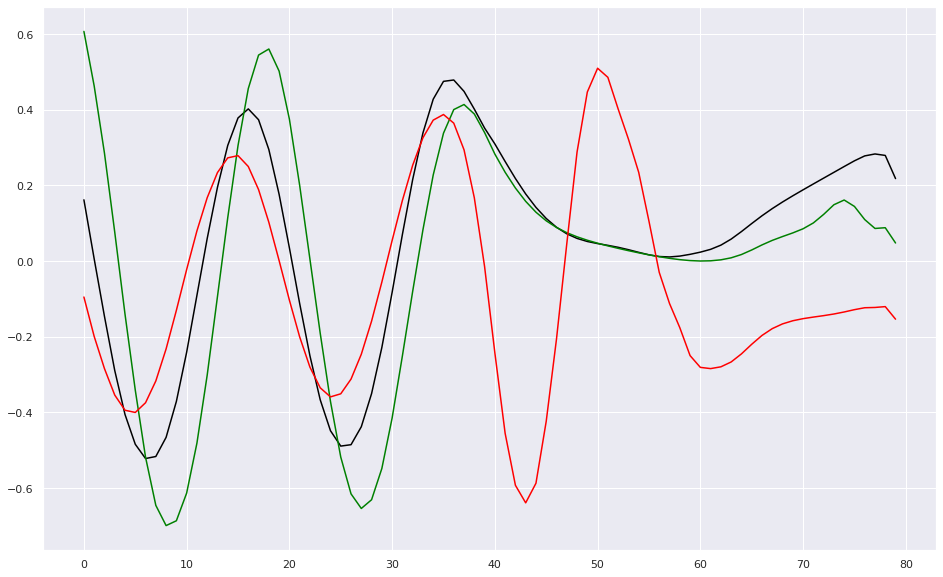

In [8]:
testNoise = noise(sample_size, seq_length*2, noise_features)
print(testNoise.size(1))
print(testNoise.shape)
testOut = generator(testNoise)
a = 0
b = 0
c = 0
da = 0.0 # plus -> high freq; minus -> lower freq
db = 0.0 # plus -> low amp; minus -> high amp
dc = 0.4
for i in range(seq_length):
    testNoise[0][i][0] = a
    testNoise[0][i][1] = b
    testNoise[0][i][2] = c

    testNoise[1][i][0] = a+da 
    testNoise[1][i][1] = b+db 
    testNoise[1][i][2] = c+dc 

    testNoise[2][i][0] = a-da 
    testNoise[2][i][1] = b-db 
    testNoise[2][i][2] = c-dc 

testOut = generator(testNoise)

plt.show()
plt.figure(figsize=(16,10))
plt.plot(testOut[0].detach().cpu(), 'black') 
plt.plot(testOut[1].detach().cpu() , 'green')
plt.plot(testOut[2].detach().cpu() , 'red')

plt.show()

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5]


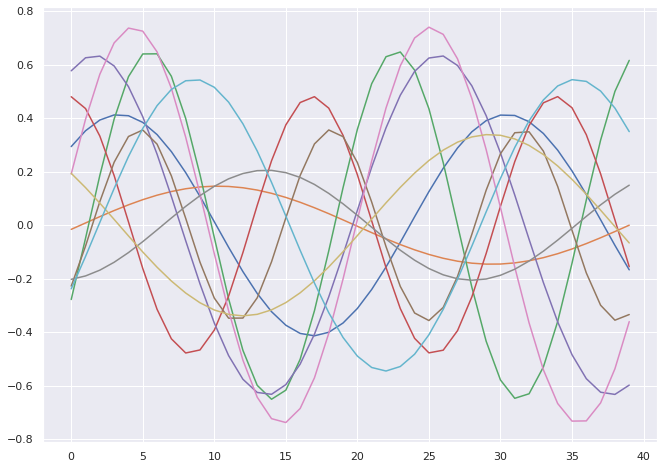

In [89]:
a = np.arange(0.1,0.9,0.02)
x = np.arange(0,20,0.5)
r = np.arange(2,6.1,0.1)

print(x)
count = 0
fs = len(x)
y = np.zeros((1,len(x)))

for n in range(100):
  amp = random.uniform(0.1, 0.9)
  rad = random.uniform(2, 6)
  phase = random.uniform(-fs/0.5*np.pi,fs/0.5*np.pi)
  y = np.append(y, amp*np.sin(((2*np.pi*rad*x)+phase)/fs).reshape((1,len(x))),axis = 0)
     
data = pd.DataFrame(y[1:][:])  
for i in range(10):
  plt.plot(y[i+1])


plt.show()